# 0. Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import distances
from scipy.linalg import expm
import os
from IPython.display import clear_output

In [41]:
print('reading files...')

# Read the tab separated file from BioLip
df = pd.read_csv('BioLiP.csv')

# list all PDB structure files
os.system('ls data/PDB_files > all_pdb_files.txt')

print('removing entry with unavailable PDB structures...')

# filter for only the data PDB structure available
avail_list = []
f = open('all_pdb_files.txt','r')
for line in f:
    avail_list.append(line[3:7])
    
avail = []
for pdb_id in df.PDB_ID:
    if pdb_id in avail_list:
        avail.append(1)
    else:
        avail.append(0)
        
# drop data with unavailable structures
df['available'] = avail
df = df[df.available==1]
df = df.reset_index(drop=True)

print('get protein sequences and length from FASTA...')

# get peptide sequences
peptide_seq = []
len_peptide_seq = []

# Read the FASTA sequence files of all filtered PDB entries
# get the peptide sequence and length to the list for each entry
# if peptide not found just add X
for i in range( len(df) ):
    found = 0
    pdb_id = df.iloc[i,:].PDB_ID    
    # seeking for peptide chain
    f = open('data/FASTA_files/%s.fasta'%pdb_id)
    for line in f:
        if( line.split()[0][0] == '>' and
            line.split()[0][-1] == df.iloc[i,:].peptide_chain_ID):
            peptide_seq.append(f.readline()[:-1])
            found = 1
            break
    if found == 0:
        peptide_seq.append('X')
    f.close()
    len_peptide_seq.append(len(peptide_seq[-1]))
            
# add the FASTA sequence column
df['peptide_seq'] = peptide_seq
df['len_peptide_seq'] = len_peptide_seq

# Then determine the length of receptors and add a column into df
len_protein_seq = []
for i in range( len(df) ):
    len_protein_seq.append(len(df.iloc[i,:]["Receptor sequence"]))    
df['len_protein_seq'] = len_protein_seq

# ****filter for only data with 3-30 amino acid peptide****
df = df[df.len_peptide_seq <= 30]
df = df[df.len_peptide_seq >= 3].reset_index(drop=True)

# ****filter for only data with 30-300 amino acid receptor protein****
df = df[df.len_protein_seq <= 300]
df = df[df.len_protein_seq >= 30].reset_index(drop=True)

print('dropping data with unknown sequences...')

# drop PDB with incomplete structural data
incomplete_entry = []
for i in range( len(df) ):
    if 'X' in df.iloc[i,:].bind_res_renum:
        incomplete_entry.append(i)
df = df.drop(incomplete_entry).reset_index(drop=True)

# other incomplete entry with missing residues
incomplete = ['3gi0']
n_entry = len(df)

for entry in range( n_entry ):
    pdb_id = df.PDB_ID[entry]
    os.system('cp data/PDB_files/pdb'+pdb_id+'.ent protein_temp.pdb')

    Receptor_chain = df.Receptor_chain[entry]
    len_protein_seq = df.len_protein_seq[entry]

    # import a pdb file as the universe
    PDB = 'protein_temp.pdb'
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames
    
    if len_protein_seq != len(seq):
        incomplete.append(pdb_id)

    # list of atom index with alternate locations (altLoc)
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            incomplete.append(pdb_id)
            break
    clear_output(wait=True)
    print('checked incomplete PDB structures: entry '+str(entry)+'/'+str(n_entry))
    
incomplete_entry = []
for pdb_id in incomplete:
    incomplete_entry += list(df[df.PDB_ID==pdb_id].index)

df = df.drop(incomplete_entry).reset_index(drop=True)

print('finalizing primary dataset...')

# drop unused columns 
# then assign protein-peptide interaction entry NO.  
df = df[["PDB_ID","Receptor_chain","peptide_chain_ID","bind_res_renum","Receptor sequence","peptide_seq","len_protein_seq","len_peptide_seq"]]
df = df.reset_index().rename(columns={"index":"entry"})


checked incomplete PDB structures: entry 18531/18532
finalizing primary dataset...


In [42]:
# list all PDB structure files

import os
os.system('ls data/PDB_files > all_pdb_files.txt')

df0 = df

# filter for only the data PDB structure available

avail_list = []
f = open('all_pdb_files.txt','r')
for line in f:
    avail_list.append(line[3:7])
    
avail = []
for pdb_id in df0.PDB_ID:
    if pdb_id in avail_list:
        avail.append(1)
    else:
        avail.append(0)
        
# drop data with unavailable structures

df0['available'] = avail
df1 = df0[df0.available==1]
df1 = df1.reset_index(drop=True)

# get peptide sequences
peptide_seq = []
len_peptide_seq = []

# Read the FASTA sequence files of all filtered PDB entries
# get the peptide sequence and length to the list for each entry
# if peptide not found just add X

for i in range( len(df1) ):
    found = 0
    pdb_id = df1.iloc[i,:].PDB_ID    
    # seeking for peptide chain
    f = open('data/FASTA_files/%s.fasta'%pdb_id)
    for line in f:
        if( line.split()[0][0] == '>' and
            line.split()[0][-1] == df1.iloc[i,:].peptide_chain_ID):
            peptide_seq.append(f.readline()[:-1])
            found = 1
            break
    if found == 0:
        peptide_seq.append('X')
    f.close()
    len_peptide_seq.append(len(peptide_seq[-1]))
            
# add the FASTA sequence column
df1['peptide_seq'] = peptide_seq
df1['len_peptide_seq'] = len_peptide_seq

# Then determine the length of receptors and add a column into df
len_protein_seq = []
for i in range( len(df1) ):
    len_protein_seq.append(len(df1.iloc[i,:]["Receptor sequence"]))    
df1['len_protein_seq'] = len_protein_seq

# filter for only data with 3-30 amino acid peptide
df2 = df1[df1.len_peptide_seq <= 30]
df3 = df2[df1.len_peptide_seq >= 3].reset_index(drop=True)

# filter for only data with 175-350 amino acid receptor protein
df4 = df3[df1.len_protein_seq <= 350]
df5 = df4[df1.len_protein_seq >= 175].reset_index(drop=True)

# drop PDB with incomplete structural data
incomplete_entry = []
for i in range( len(df5) ):
    if 'X' in df5.iloc[i,:].bind_res_renum:
        incomplete_entry.append(i)
df5 = df5.drop(incomplete_entry).reset_index(drop=True)

In [43]:
from IPython.display import clear_output

# other incomplete entry with missing residues
incomplete = ['3gi0']
n_entry = len(df5.entry)

for entry in range(n_entry):
    pdb_id = df.PDB_ID[entry]
    os.system('cp data/PDB_files/pdb'+pdb_id+'.ent protein_temp_.pdb')

    Receptor_chain = df.Receptor_chain[entry]
    len_protein_seq = df.len_protein_seq[entry]

    # import a pdb file as the universe
    PDB = 'protein_temp_.pdb'
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames
    
    if len_protein_seq != len(seq):
        incomplete.append(pdb_id)

    # list of atom index with alternate locations (altLoc)
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            incomplete.append(pdb_id)
            break
    clear_output(wait=True)
    print(str(entry)+'/'+str(n_entry))
    
incomplete_entry = []
for pdb_id in incomplete:
    incomplete_entry += list(df5[df5.PDB_ID==pdb_id].index)

df5 = df5.drop(incomplete_entry).reset_index(drop=True)

6595/6596


In [263]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import distances
from scipy.linalg import expm
import os

### sequence and structural network module

def network(df,entry):
    pdb_id = df.PDB_ID.iloc[entry]
    os.system('cp data/PDB_files/pdb'+pdb_id+'.ent protein_temp_.pdb')

    Receptor_chain = df.Receptor_chain.iloc[entry]
    peptide_chain_ID = df.peptide_chain_ID.iloc[entry]

    # import a pdb file as the universe
    PDB = 'protein_temp_.pdb'
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames

    # list of atom index with alternate locations (altLoc)
    alt_index = []
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            alt_index.append(i)

    # positions of all c-alpha atoms - dropping altLoc - trim data to match the FASTA
    pos_CA = np.delete(CA.positions,alt_index,axis=0)
    n_amino = df.iloc[entry,:].len_protein_seq
    pos_CA = pos_CA[:n_amino]
    sequence = np.delete(seq,alt_index)
    sequence = sequence[:n_amino]

    # distance matrix
    dist_mat = distances.distance_array(pos_CA, 
                                        pos_CA, 
                                        box=u.dimensions)

    # adjacency matrix
    cutoff = 7  # cutoff distance 
    A = dist_mat - cutoff; A[A>0] = 0; A[A<0] = 1

    # communicability matrix (G) 
    # and (relative) subgraph centrality (SC)
    G = expm(A); SC = G.diagonal()/np.min(G.diagonal())

    return A, G, SC, sequence

def binding_data(df,entry,A,G,SC):
    # get binding residues
    bind_res_str = df.bind_res_renum[entry].split()
    bind_res_index = [int(r[1:])-1 for r in bind_res_str]
    bind_res_index = [res for res in bind_res_index if res < len(A)]
    bind_res_num = len(bind_res_index)
    return bind_res_index, bind_res_num

In [277]:
from IPython.display import clear_output

# drop unused columns 
# then assign protein-peptide interaction numbers (PPI_no) 
df6 = df5[["PDB_ID","Receptor_chain","peptide_chain_ID","bind_res_renum","Receptor sequence","peptide_seq","len_protein_seq","len_peptide_seq"]]
df = df6.reset_index().rename(columns={"index":"entry"})

n_entry = len(df.entry)

# create lists of residue indices
bind_res_num_list = list(range(n_entry))
bind_res_index_list = list(range(n_entry))

for entry in range(n_entry):
    A, G, SC, sequence = network(df,entry)
    bind_res_index, bind_res_num = binding_data(df,entry,A,G,SC)
    bind_res_num_list[entry] = bind_res_num
    bind_res_index_list[entry] = bind_res_index
    clear_output(wait=True)
    print(str(entry)+'/'+str(n_entry))

# then add bind_res_num as another column
df['bind_res_num'] = bind_res_num_list
df['bind_res_index'] = bind_res_index_list

# index the unique proteins
protein_no = np.zeros(len(df.PDB_ID),dtype='int')
count = 0
for i in range(1,len(df.PDB_ID)):
    if df.PDB_ID[i] == df.PDB_ID[i-1]:
        protein_no[i] = count
    else:
        count += 1
        protein_no[i] = count
df['protein_no'] = protein_no
df7 = df

6595/6596


In [300]:
# shuffle the dataset and cut 80%/20% of entries as train/test sets
n_entry = len(df7.entry)
entry_random = np.random.permutation(range(n_entry))

df7 = df7.iloc[entry_random]

# drop data with chain ID in lowercase letters (MAC is not case sensitive)
list_Receptor_chain = df7.Receptor_chain
list_peptide_chain_ID = df7.peptide_chain_ID
lowercase_index = []
for i in range(len(list_Receptor_chain)):
    if list_Receptor_chain[i] in 'abcdefghijklmnopqrstuvwxyz' or list_peptide_chain_ID[i] in 'abcdefghijklmnopqrstuvwxyz':
        lowercase_index.append(i)
df8 = df7.drop(lowercase_index)
        
df8 = df8.reset_index(drop=False)
df8 = df8.reset_index(drop=False)
df8 = df8.drop(columns=["entry","index"])
df8 = df8.rename(columns={"level_0":"entry"})

n_train = int(0.8*n_entry)
df_test = df8.iloc[n_train:,:].reset_index(drop=True)
df_train = df8.iloc[:n_train,:].reset_index(drop=True)

df_train['entry'] = range(len(df_train))
df_test['entry'] = range(len(df_test))
df = df_train

In [301]:
df8

,entry,PDB_ID,Receptor_chain,peptide_chain_ID,bind_res_renum,Receptor sequence,peptide_seq,len_protein_seq,len_peptide_seq,bind_res_num,bind_res_index,protein_no
0,0,4u39,B,K,L247 Q251 V265 F269 G270 S271,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925
1,1,4pie,A,B,E88 R92 A95 R102 C103 I104 T105 L106 E107 K108...,GSSEQELKAIVKDLGCGPYFLGTYDKRFPGFVSPHKLACAIVNTAG...,GVQSLKRRRCF,202,11,17,"[87, 91, 94, 101, 102, 103, 104, 105, 106, 107...",1881
2,2,5ni7,A,C,K79 Q89 I93 K97 P243 E247,ENLYFQGASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSRE...,KHKILHRLLQDS,252,12,6,"[78, 88, 92, 96, 242, 246]",2261
3,3,1xb7,A,P,K48 Q61 E211,LEVLFQGPVNALVSHLLVVEPEKLYAMAVATLCDLFDREIVVTISW...,SELLKYLTT,215,9,3,"[47, 60, 210]",659
4,4,1h8d,H,L,E8 G10 M11 P13 W14 D113 H116 P117 C119 Y134 K1...,IVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLL...,EADCGLRPLFEKKSLEDKTERELLESYI,251,28,18,"[7, 9, 10, 12, 13, 112, 115, 116, 118, 133, 13...",219
...,...,...,...,...,...,...,...,...,...,...,...,...
6267,6267,4zri,A,C,E117 N156 L157 Y158 Q159 W165 R168 W172 E187 I191,KTFTVRIVTMDAEMEFNCEMKWKGKDLFDLVCRTLGLRETWFFGLQ...,GPYQKALREIRYSLLPFANE,293,20,10,"[116, 155, 156, 157, 158, 164, 167, 171, 186, ...",1996
6268,6268,3tbt,G,I,Y7 E63 K66 Q70 W73 S77 N80 Y84 Q97 S99 F116 T1...,GPHSMRYFETAVSRPGLEEPRYISVGYVDNKEFVRFDSDAENPRYE...,KAPSNFATM,269,9,18,"[6, 62, 65, 69, 72, 76, 79, 83, 96, 98, 115, 1...",1506
6269,6269,5u1g,A,R,P109 V149 E152 S153 D156,MKVISFLNPKGGSGKTTAVINIATALSRSGYNIAVVDTDPQMSLTN...,SVKKMTFGEN,211,10,5,"[108, 148, 151, 152, 155]",2335
6270,6270,4u6g,A,C,W33 G55 E56 K103 Y105 F107 P113,EVQLVESGGGLVKPGGSLRLSCSASGFDFDNAWMTWVRQPPGKGLE...,SLWNWFNITNLWIKK,232,15,7,"[32, 54, 55, 102, 104, 106, 112]",1927


In [302]:
df

,entry,PDB_ID,Receptor_chain,peptide_chain_ID,bind_res_renum,Receptor sequence,peptide_seq,len_protein_seq,len_peptide_seq,bind_res_num,bind_res_index,protein_no
0,0,4u39,B,K,L247 Q251 V265 F269 G270 S271,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925
1,1,4pie,A,B,E88 R92 A95 R102 C103 I104 T105 L106 E107 K108...,GSSEQELKAIVKDLGCGPYFLGTYDKRFPGFVSPHKLACAIVNTAG...,GVQSLKRRRCF,202,11,17,"[87, 91, 94, 101, 102, 103, 104, 105, 106, 107...",1881
2,2,5ni7,A,C,K79 Q89 I93 K97 P243 E247,ENLYFQGASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSRE...,KHKILHRLLQDS,252,12,6,"[78, 88, 92, 96, 242, 246]",2261
3,3,1xb7,A,P,K48 Q61 E211,LEVLFQGPVNALVSHLLVVEPEKLYAMAVATLCDLFDREIVVTISW...,SELLKYLTT,215,9,3,"[47, 60, 210]",659
4,4,1h8d,H,L,E8 G10 M11 P13 W14 D113 H116 P117 C119 Y134 K1...,IVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLL...,EADCGLRPLFEKKSLEDKTERELLESYI,251,28,18,"[7, 9, 10, 12, 13, 112, 115, 116, 118, 133, 13...",219
...,...,...,...,...,...,...,...,...,...,...,...,...
5271,5271,2uz6,E,N,V106 M114 I116 S165,QANLMRLKSDLFNRSPMYPGPTKDDPLTVTLGFTLQDIVKVDSSTN...,GCCSRPPCILNNPDLC,205,16,4,"[105, 113, 115, 164]",1049
5272,5272,2c1j,B,D,K49 R56 R127 Y128 N173 V176 E180 D223 N224,MDKNELVQKAKLAEQAERYDDMAACMKSVTEQGAELSNEERNLLSV...,ARTGGK,230,6,9,"[48, 55, 126, 127, 172, 175, 179, 222, 223]",795
5273,5273,3l3x,A,B,V48 K52 R58 M66 Q70 M226,SQPIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVH...,HKKLLQLLTCSS,250,12,6,"[47, 51, 57, 65, 69, 225]",1349
5274,5274,3mlu,L,P,D28 K29 Y30 W89 A91 T100,YLLTQPPSVSVSPGQTASISCSGDKLDDKYVSWYYQRPGQSPVLLM...,TRKSIRIGPGQAFY,218,14,6,"[27, 28, 29, 88, 90, 99]",1377


In [229]:
df_test

,PDB_ID,Receptor_chain,peptide_chain_ID,bind_res_renum,Receptor sequence,peptide_seq,len_protein_seq,len_peptide_seq,bind_res_num,bind_res_index,protein_no,entry
0,3hae,P,R,Y7 E63 K66 V67 H70 T73 D77 T80 Y99 Y116 T143 K...,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,SLLMWITQV,276,9,16,"[6, 62, 65, 66, 69, 72, 76, 79, 98, 115, 142, ...",1286,0
1,5ifj,G,I,A33 W47 S52 Y59 G101 K102 D103,EVQLLESGGGLVQPGGSLRLSCAASGFTFSTYAMSWVRQAPGKGLE...,PLQPEQPFP,215,9,7,"[32, 46, 51, 58, 100, 101, 102]",2189,1
2,1jg3,A,C,P52 P54 T60 S62 A63 H65 M66 V203 A204 F205 V206,EKELYEKWMRTVEMLKAEGIIRSKEVERAFLKYPRYLSVEDKYKKY...,VYPHA,215,5,11,"[51, 53, 59, 61, 62, 64, 65, 202, 203, 204, 205]",272,2
3,5wzz,B,F,L66 D70 I71 V72 F73 L74 A75 T76 D85 W86 V87,SVLFPCKYASSGCEITLPHTEKADHEELCEFRPYSCPCPGASCKWQ...,KEVRVEPQK,190,9,11,"[65, 69, 70, 71, 72, 73, 74, 75, 84, 85, 86]",2389,3
4,2dym,G,H,H2 I6 L9 L10 L15 N16 V17 R34 R36 R39 S90 F91 D...,AHMNDIKQLLWNGELNVLVSIDPSFLMKEIAVLRIRVPRETYLVNY...,SMDDLLIRRLTDRNDKEAHLNELF,262,24,20,"[1, 5, 8, 9, 14, 15, 16, 33, 35, 38, 89, 90, 9...",828,4
...,...,...,...,...,...,...,...,...,...,...,...,...
991,2stb,E,I,Y22 F24 C25 H40 S171 C172 Q173 G174 S176 S191 ...,IVGGYECKPYSQPHQVSLNSGYHFCGGSLVNENWVVSAAHCYKSRV...,RVCPKILMECKKDSDCLAECICLEHGYCG,222,29,13,"[21, 23, 24, 39, 170, 171, 172, 173, 175, 190,...",1045,991
992,2h4f,A,D,R34 H110 V154 F156 G157 E158 N159 L160 L165 V1...,MKMKEFLDLLNESRLTVTLTGAGISTPSGIPDFRGPYSQNVFDIDF...,SRHKLMF,240,7,13,"[33, 109, 153, 155, 156, 157, 158, 159, 164, 1...",888,992
993,2z4j,A,B,K50 M64 Q68 M224,PIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVV...,PSILKKILLE,248,10,4,"[49, 63, 67, 223]",1101,993
994,6b77,B,A,C114 Q200 A201 E203 R204 R205,VVGGLVALRGAHPYIAALYWGHSFCAGSLIAPCWVLTAAHCLQDRP...,NGPLSCGQR,243,9,6,"[113, 199, 200, 202, 203, 204]",2499,994


# 1. Binding Site Identification Model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import distances
from scipy.linalg import expm
import os

In [345]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import distances
from scipy.linalg import expm
import os


# create lists of dipeptide and tripeptide PCP characteristics

def initialize_dipeptide_tripeptide():
    dipeptide_name = []
    for amino1 in ['R','L','P','N','U']:
        for amino2 in ['R','L','P','N','U']:
            dipeptide_name.append(amino1+amino2)

    tripeptide_name = []
    for amino1 in ['R','L','P','N','U']:
        for amino2 in ['R','L','P','N','U']:
            for amino3 in ['R','L','P','N','U']:
                tripeptide_name.append(amino1+amino2+amino3)

    return dipeptide_name, tripeptide_name
 

# convert amino acids into physico-chemical properties (PCP)            
            
def pcp_convert(amino):
    if amino in ['PHE', 'TRP', 'TYR', 'F', 'W', 'Y']:
        pcp = 'R'
    elif amino in ['ILE','VAL','LEU','ALA','GLY','PRO','MET','I','V','L','A','G','P','M']:
        pcp = 'L'
    elif amino in ['LYS', 'ARG', 'HIS', 'K', 'R', 'H']:
        pcp = 'P'
    elif amino in ['ASP', 'GLU', 'D', 'E']:
        pcp = 'N'
    elif amino in ['SER', 'CYS', 'THR', 'ASN', 'GLN', 'S', 'C', 'T', 'N', 'Q']:
        pcp = 'U'
    else:
        pcp = 'L'
    return pcp
            
# create tripeptide vectors of size 125:
# 111, 112, ..., 121, 122, ..., 211, 212, ..., 555
# add +1 onto one-hot feature vector of matched tripeptide

'''
def dipeptide_convert(a1,a2,a3):
    tripeptide_vec = np.zeros(125)
    tripeptide = pcp_convert(a1) + pcp_convert(a2) + pcp_convert(a3)
    tripeptide_vec[ tripeptide_name.index(tripeptide) ] += 1
    return tripeptide_vec
'''

def dipeptide_convert(a1,a2):
    dipeptide_vec = np.zeros(25)
    dipeptide = pcp_convert(a1) + pcp_convert(a2)
    dipeptide_vec[ dipeptide_name.index(dipeptide) ] += 1
    return dipeptide_vec

def tripeptide_convert(a1,a2,a3):
    tripeptide_vec = np.zeros(125)
    tripeptide = pcp_convert(a1) + pcp_convert(a2) + pcp_convert(a3)
    tripeptide_vec[ tripeptide_name.index(tripeptide) ] += 1
    return tripeptide_vec
    
# primary tripeptide featurizer for protein
def protein_tripep_feats(res_index, A, sequence):

    # searching for non-clustering neighbor tripep residues XYZ 
    # consider Y that (adjacency) A(X,Y)=1 and A(Y,Z)=1 and A(X,Z)=0 
    index_Y = res_index
    index_X_Z = np.where(A[index_Y]==1)[0]  # A(X,Y)=1 and A(Y,Z)=1
    A_X_Z = A[index_X_Z][:,index_X_Z]  # submatrix of A at X and Z

    index_X = index_X_Z[ np.where(A_X_Z==0)[0] ]  # getting the satisfied X
    index_Z = index_X_Z[ np.where(A_X_Z==0)[1] ]  # getting the satisfied Z
    
    # FEATURE 1-125: tripeptide counts 
    # getting tripeptide sequence and convert into a 125-element vector
    tripep_feat_vec = np.zeros(125)
    for i in range(len(index_X)):
        tripep_feat_vec += tripeptide_convert(sequence[ index_X[i] ],
                                       sequence[ index_Y ],
                                       sequence[ index_Z[i] ])  
    # weight the frequency of finding each type of tripeptide by probability    
    tripep_feat_vec = tripep_feat_vec / (2*len(index_X)+1)
    return tripep_feat_vec


# primary featurizer for peptide based on upto 4th nearest neighbors 
def peptide_dipep_feats(df, entry):
    
    # peptide length
    peptide_seq = df.peptide_seq.iloc[entry]
    peptide_length = df.len_peptide_seq.iloc[entry]

    # searching for neighbor residues XY and YZ
    # for 1st, 2nd, 3rd, and 4th-order nearest neighbors
    dipep_index = [[],[],[],[]]
    for res_index in range(peptide_length):
        for order in range(1,5):
            index_X = res_index - order
            index_Y = res_index
            index_Z = res_index + order
            if index_Z < peptide_length and index_X >= 0:
                dipep_index[order-1].append([index_X,index_Y])
                dipep_index[order-1].append([index_Y,index_Z])
    
    # FEATURE 1-100: dipeptide counts 
    # getting dipeptide sequence and convert into a 25-element vector for each order
    dipep_feat_vec = np.zeros(100)
    for order_1 in range(4):
        for i_dipep in dipep_index[order_1]:
            dipep_feat_vec[order_1*25:(order_1+1)*25] += dipeptide_convert(peptide_seq[ i_dipep[0] ],
                                           peptide_seq[ i_dipep[1] ])  
    # weight the frequency of finding each type of dipeptide by peptide length    
    dipep_feat_vec = dipep_feat_vec / np.sqrt(peptide_length)
    return dipep_feat_vec    


In [303]:
# create files containing feature vectors of unique proteins
import os
from IPython.display import clear_output

n_entry = len(df8)
for entry in range(n_entry):
    pdb_id = df8.iloc[entry].PDB_ID
    chain_id = df8.iloc[entry].Receptor_chain
    if pdb_id+'_'+chain_id+'.feat' not in os.listdir('data/feat_files'): 
        A, G, SC, sequence = network(df8,entry)
        n_amino = len(A)
        feat125 = np.zeros((n_amino,125))
        for res_index in range(n_amino):
            feat125[res_index] = protein_tripep_feats(res_index,A,sequence)
        np.savetxt('data/feat_files/'+pdb_id+'_'+chain_id+'.feat',feat125,fmt='%9.4f')
        np.savetxt('data/SC_files/'+pdb_id+'_'+chain_id+'.SC',SC,fmt='%9.4f')
        np.savetxt('data/deg_files/'+pdb_id+'_'+chain_id+'.deg',np.sum(A,axis=1),fmt='%9.4f')
        np.savetxt('data/commu_files/'+pdb_id+'_'+chain_id+'.commu',np.sum(G,axis=1),fmt='%9.4f')
    clear_output(wait=True)
    #print(pdb_id)
    print(str(entry)+'/'+str(n_entry))

6271/6272


In [304]:
from IPython.display import clear_output

# create dataset with binding residue classes for all residues - TRAIN SET

# reset dataframe
data_all_res = df.drop(range(len(df.PDB_ID)))

n_entry = len(df.entry)
# add multiple data points for each PPI entry by residue index
data_entry_mult_list = list(range(n_entry))
for entry in range(n_entry):
    data_entry = df[df.entry==entry]
    pdb_id = data_entry.iloc[0].PDB_ID
    chain_id = data_entry.iloc[0].Receptor_chain
    n_amino = len(np.loadtxt('data/SC_files/'+pdb_id+'_'+chain_id+'.SC'))
    data_entry_list = [data_entry for i in range(n_amino)]
    data_entry_mult = pd.concat(data_entry_list,ignore_index=True)

    # add residue index column
    data_entry_mult['res_index'] = range(n_amino)

    # then add binding residue class (bind_res_class: 1 is binding)
    bind_res_class_array = np.zeros(n_amino,dtype='int')
    bind_res_class_array[data_entry.iloc[0,:].bind_res_index] = 1
    data_entry_mult['bind_res_class'] = bind_res_class_array   
        
    # adding multiple data points to the list for concatanation
    data_entry_mult_list[entry] = data_entry_mult

    clear_output(wait=True)
    print(str(entry)+'/'+str(n_entry))
    
data_all_res = pd.concat(data_entry_mult_list,ignore_index=True)
data_all_res = data_all_res.drop(columns=["bind_res_renum"])
data_all_res.to_csv('data_all_res.csv')

5275/5276


In [305]:
# create dataset with binding residue classes for all residues - TEST SET

# reset dataframe
data_all_res_test = df_test.drop(range(len(df_test.PDB_ID)))

n_entry = len(df_test.entry)
# add multiple data points for each PPI entry by residue index
data_entry_mult_list = list(range(n_entry))
for entry in range(n_entry):
    data_entry = df_test[df_test.entry==entry]
    pdb_id = data_entry.iloc[0].PDB_ID
    chain_id = data_entry.iloc[0].Receptor_chain
    n_amino = len(np.loadtxt('data/SC_files/'+pdb_id+'_'+chain_id+'.SC'))
    data_entry_list = [data_entry for i in range(n_amino)]
    data_entry_mult = pd.concat(data_entry_list,ignore_index=True)

    # add residue index column
    data_entry_mult['res_index'] = range(n_amino)

    # then add binding residue class (bind_res_class: 1 is binding)
    bind_res_class_array = np.zeros(n_amino,dtype='int')
    bind_res_class_array[data_entry.iloc[0,:].bind_res_index] = 1
    data_entry_mult['bind_res_class'] = bind_res_class_array   
        
    # adding multiple data points to the list for concatanation
    data_entry_mult_list[entry] = data_entry_mult

    clear_output(wait=True)
    print(str(entry)+'/'+str(n_entry))
    
data_all_res_test = pd.concat(data_entry_mult_list,ignore_index=True)
data_all_res_test = data_all_res_test.drop(columns=["bind_res_renum"])
data_all_res_test.to_csv('data_all_res_test.csv')

995/996


In [76]:
data_all_res = pd.read_csv('data_all_res.csv')

In [374]:
df

,entry,PDB_ID,Receptor_chain,peptide_chain_ID,bind_res_renum,Receptor sequence,peptide_seq,len_protein_seq,len_peptide_seq,bind_res_num,bind_res_index,protein_no
0,0,4u39,B,K,L247 Q251 V265 F269 G270 S271,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925
1,1,4pie,A,B,E88 R92 A95 R102 C103 I104 T105 L106 E107 K108...,GSSEQELKAIVKDLGCGPYFLGTYDKRFPGFVSPHKLACAIVNTAG...,GVQSLKRRRCF,202,11,17,"[87, 91, 94, 101, 102, 103, 104, 105, 106, 107...",1881
2,2,5ni7,A,C,K79 Q89 I93 K97 P243 E247,ENLYFQGASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSRE...,KHKILHRLLQDS,252,12,6,"[78, 88, 92, 96, 242, 246]",2261
3,3,1xb7,A,P,K48 Q61 E211,LEVLFQGPVNALVSHLLVVEPEKLYAMAVATLCDLFDREIVVTISW...,SELLKYLTT,215,9,3,"[47, 60, 210]",659
4,4,1h8d,H,L,E8 G10 M11 P13 W14 D113 H116 P117 C119 Y134 K1...,IVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLL...,EADCGLRPLFEKKSLEDKTERELLESYI,251,28,18,"[7, 9, 10, 12, 13, 112, 115, 116, 118, 133, 13...",219
...,...,...,...,...,...,...,...,...,...,...,...,...
5271,5271,2uz6,E,N,V106 M114 I116 S165,QANLMRLKSDLFNRSPMYPGPTKDDPLTVTLGFTLQDIVKVDSSTN...,GCCSRPPCILNNPDLC,205,16,4,"[105, 113, 115, 164]",1049
5272,5272,2c1j,B,D,K49 R56 R127 Y128 N173 V176 E180 D223 N224,MDKNELVQKAKLAEQAERYDDMAACMKSVTEQGAELSNEERNLLSV...,ARTGGK,230,6,9,"[48, 55, 126, 127, 172, 175, 179, 222, 223]",795
5273,5273,3l3x,A,B,V48 K52 R58 M66 Q70 M226,SQPIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVH...,HKKLLQLLTCSS,250,12,6,"[47, 51, 57, 65, 69, 225]",1349
5274,5274,3mlu,L,P,D28 K29 Y30 W89 A91 T100,YLLTQPPSVSVSPGQTASISCSGDKLDDKYVSWYYQRPGQSPVLLM...,TRKSIRIGPGQAFY,218,14,6,"[27, 28, 29, 88, 90, 99]",1377


In [373]:
data_all_res

,entry,PDB_ID,Receptor_chain,peptide_chain_ID,Receptor sequence,peptide_seq,len_protein_seq,len_peptide_seq,bind_res_num,bind_res_index,protein_no,res_index,bind_res_class
0,0,4u39,B,K,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925,0,0
1,0,4u39,B,K,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925,1,0
2,0,4u39,B,K,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925,2,0
3,0,4u39,B,K,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925,3,0
4,0,4u39,B,K,SIKVIGVGGGGNNAVNRMIENEVQGVEYIAVNTDAQALNLSKAEVK...,VVLVAWEIRAKLKEY,289,15,6,"[246, 250, 264, 268, 269, 270]",1925,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233320,5275,1toc,H,G,IVEGQDAEVGLSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLL...,ADCGLRPLFEKKQVQDQTEKELFESYIE,259,28,19,"[7, 10, 12, 13, 115, 116, 117, 118, 128, 130, ...",590,254,0
1233321,5275,1toc,H,G,IVEGQDAEVGLSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLL...,ADCGLRPLFEKKQVQDQTEKELFESYIE,259,28,19,"[7, 10, 12, 13, 115, 116, 117, 118, 128, 130, ...",590,255,0
1233322,5275,1toc,H,G,IVEGQDAEVGLSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLL...,ADCGLRPLFEKKQVQDQTEKELFESYIE,259,28,19,"[7, 10, 12, 13, 115, 116, 117, 118, 128, 130, ...",590,256,0
1233323,5275,1toc,H,G,IVEGQDAEVGLSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLL...,ADCGLRPLFEKKQVQDQTEKELFESYIE,259,28,19,"[7, 10, 12, 13, 115, 116, 117, 118, 128, 130, ...",590,257,0


In [479]:
# extract peptide features and assign features on each amino acid
# - load amino acid triad (tripeptide) features from each protein structure
# - extract features from peptide sequence for each entry - copy to each residue of receptor
# - assign topological features (SC / degree / commu) to each residue of receptor

data_all = data_all_res

n_entry = len(df)
n_data = len(data_all)

# matrix containing 253-feature vectors of all protein residues
X = np.zeros((n_data,253))

# interaction features
index_frequency = np.zeros((25,125,25))
index_coeff_125 = np.zeros((25,125))
index_coeff_25 = np.zeros((25,25))

#index_dipeptide = np.zeros((125,25,6))
for i in range(125):
    for j in range(25):
        for amino_i in tripeptide_name[i]:
            for amino_j in dipeptide_name[j]:
                index_dipeptide = dipeptide_name.index(amino_i+amino_j)
                index_frequency[index_dipeptide,i,j] += 1
for k in range(25):
    index_coeff_125[k] = np.sum(index_frequency[k],axis=1)
    index_coeff_25[k] = np.sum(index_frequency[k],axis=0)

# assign features
# 1-125 : protein (receptor) amino acid triad features
# 126-225 : peptide features (25 features for each neighboring order)
# 226-250 : interaction features
# 251-253 : network features
i_res = 0
for entry in range(n_entry):
    pdb_id = df.iloc[entry].PDB_ID
    chain_id = df.iloc[entry].Receptor_chain
    feat125 = np.loadtxt('data/feat_files/'+pdb_id+'_'+chain_id+'.feat')
    n_amino = len(feat125)
    X[i_res:i_res+n_amino,:125] = feat125
    pep100 = peptide_dipep_feats(df, entry)
    pep25 = 0.25*(pep100[:25]+pep100[25:50]+pep100[50:75]+pep100[75:])
    for i_amino in range(n_amino):
        X[i_res+i_amino,125:225] = pep100
        X[i_res+i_amino,225:250] = (np.dot(feat125[i_amino],np.transpose(index_coeff_125))
                    + np.dot(pep25,np.transpose(index_coeff_25)))
    X[i_res:i_res+n_amino,250] = np.loadtxt('data/SC_files/'+pdb_id+'_'+chain_id+'.SC')
    X[i_res:i_res+n_amino,251] = np.loadtxt('data/deg_files/'+pdb_id+'_'+chain_id+'.deg')
    X[i_res:i_res+n_amino,252] = np.loadtxt('data/commu_files/'+pdb_id+'_'+chain_id+'.commu')
    i_res += n_amino
    
    clear_output(wait=True)
    print(str(entry)+'/'+str(n_entry))


5275/5276


In [480]:
# data oversampling

from sklearn.model_selection import train_test_split

df_175_350 = df
data_175_350 = data_all_res

X_175_350 = X
y_175_350 = data_175_350.bind_res_class

# create and concat a featurized dataframe from the numpy array
data_X_175_350 = pd.DataFrame(X_175_350)
data_X_175_350 = pd.concat([data_175_350,data_X_175_350],axis=1)

# separate the negative data (non-binding site) for training and testing
data_negative = data_X_175_350[data_X_175_350.bind_res_class==0]
data_negative_X = data_negative.iloc[:,-253:]
data_negative_y = data_negative.bind_res_class

# Train-test splitting: negative data
data_negative_X_train, data_negative_X_test, data_negative_y_train, data_negative_y_test = train_test_split(data_negative_X, data_negative_y, test_size=0.20)

# separate the positive data (binding site) for training and testing
data_positive = data_X_175_350[data_X_175_350.bind_res_class==1]
data_positive_X = data_positive.iloc[:,-253:]
data_positive_y = data_positive.bind_res_class

# Train-test splitting: negative data
data_positive_X_train, data_positive_X_test, data_positive_y_train, data_positive_y_test = train_test_split(data_positive_X, data_positive_y, test_size=0.20)

# oversampling: 20 x positive (binding site) 
data_positive_X_train_list = [data_positive_X_train for i in range(20)]
data_positive_X_train_x20 = pd.concat(data_positive_X_train_list,ignore_index=True)
data_positive_X_test_list = [data_positive_X_test for i in range(20)]
data_positive_X_test_x20 = pd.concat(data_positive_X_test_list,ignore_index=True)
data_positive_y_train_list = [data_positive_y_train for i in range(20)]
data_positive_y_train_x20 = pd.concat(data_positive_y_train_list,ignore_index=True)
data_positive_y_test_list = [data_positive_y_test for i in range(20)]
data_positive_y_test_x20 = pd.concat(data_positive_y_test_list,ignore_index=True)

# combine into the new X y train and test
X_train = pd.concat([data_negative_X_train,data_positive_X_train_x20],ignore_index=True)
X_test = pd.concat([data_negative_X_test,data_positive_X_test_x20],ignore_index=True)
y_train = pd.concat([data_negative_y_train,data_positive_y_train_x20],ignore_index=True)
y_test = pd.concat([data_negative_y_test,data_positive_y_test_x20],ignore_index=True)

# numbers of positive and negative data points
n_positive = len(data_positive)
n_negative = len(data_negative)

In [505]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Prepare training and test datasets - REMOVE THIS FOR NEW OVERSAMPLING REGIME
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Binary Classification Models
models = {
    #"Logistic Regression": LogisticRegression(),
    #"Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    #"Gradient Boosting": GradientBoostingClassifier(),
    #"AdaBoost": AdaBoostClassifier(),
    #"SVM": SVC(),
    #"K-Nearest Neighbors": KNeighborsClassifier(),
    #"Naive Bayes": GaussianNB(),
}
for name, model in models.items():
    model.fit(X_train.iloc[:,-28:], y_train)

#for name, model in models.items():
#    model.fit(X_train, y_train)

#for name, model in models.items():
    #model.fit(X_train[::100], y_train[::100])

---TRAIN SET---- Random Forest
C_chart= [[942542   1662]
 [     0 849100]]
Accuracy: 0.9991


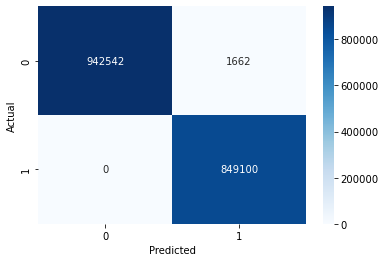

------------------------------------------------------------------------------------
---TEST SET---- Random Forest
C_chart= [[234182   1870]
 [ 98620 113660]]
Accuracy: 0.7759


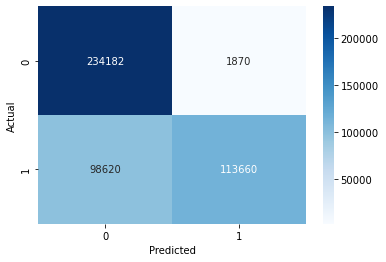

In [506]:
C_chart_mat = []  # To store accuracy scores for each fold
class_names = list(data_all_res.bind_res_class.unique())
for name, model in models.items():
    #y_pred = model.predict(X_train)
    y_pred = model.predict(X_train.iloc[:,-28:])
    
    # Calculate the confusion matrix
    C_chart = confusion_matrix(y_train, y_pred)
    C_chart_mat.append(C_chart)
    print("---TRAIN SET----", name)
    print("C_chart=", C_chart)
    # Calculating Accuracy directly for the multi-class scenario
    accuracy = accuracy_score(y_train, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    # Visualize the confusion matrix
    import seaborn as sns
    sns.heatmap(C_chart, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print('------------------------------------------------------------------------------------')
    
C_chart_mat = []  # To store accuracy scores for each fold
class_names = list(data_all_res.bind_res_class.unique())
for name, model in models.items():
    #y_pred = model.predict(X_test)
    y_pred = model.predict(X_test.iloc[:,-28:])
    
    # Calculate the confusion matrix
    C_chart = confusion_matrix(y_test, y_pred)
    C_chart_mat.append(C_chart)
    print("---TEST SET----", name)
    print("C_chart=", C_chart)
    # Calculating Accuracy directly for the multi-class scenario
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    # Visualize the confusion matrix
    import seaborn as sns
    sns.heatmap(C_chart, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [413]:
# sensitivity
127360/(127360+234163)

0.3522874063337602

In [414]:
# specificity
234163/(127360+234163)

0.6477125936662398

# 2. Screening Task

In [409]:
### sequence and structural network module

def network_from_PDB(PDB):
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA')
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames

    # list of atom index with alternate locations (altLoc)
    alt_index = []
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            alt_index.append(i)

    # positions of all c-alpha atoms - dropping altLoc - trim data to match the FASTA
    pos_CA = np.delete(CA.positions,alt_index,axis=0)
    n_amino = len(seq)
    pos_CA = pos_CA[:n_amino]
    sequence = np.delete(seq,alt_index)
    sequence = sequence[:n_amino]

    # distance matrix
    dist_mat = distances.distance_array(pos_CA, 
                                        pos_CA, 
                                        box=u.dimensions)

    # adjacency matrix
    cutoff = 7  # cutoff distance 
    A = dist_mat - cutoff; A[A>0] = 0; A[A<0] = 1

    # communicability matrix (G) 
    # and (relative) subgraph centrality (SC)
    G = expm(A); SC = G.diagonal()/np.min(G.diagonal())

    return A, G, SC, sequence

### network with varied cutoff

def network_from_PDB_cutoff(PDB,cutoff):
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA')
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames

    # list of atom index with alternate locations (altLoc)
    alt_index = []
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            alt_index.append(i)

    # positions of all c-alpha atoms - dropping altLoc - trim data to match the FASTA
    pos_CA = np.delete(CA.positions,alt_index,axis=0)
    n_amino = len(seq)
    pos_CA = pos_CA[:n_amino]
    sequence = np.delete(seq,alt_index)
    sequence = sequence[:n_amino]

    # distance matrix
    dist_mat = distances.distance_array(pos_CA, 
                                        pos_CA, 
                                        box=u.dimensions)

    # adjacency matrix
    A = dist_mat - cutoff; A[A>0] = 0; A[A<0] = 1

    # communicability matrix (G) 
    # and (relative) subgraph centrality (SC)
    G = expm(A); SC = G.diagonal()/np.min(G.diagonal())

    return A, G, SC

In [515]:
# load the peptide data and screen for only peptides with lengths <30

pep_data = pd.read_csv('general_amps.csv')
pep_data = pep_data[["Name","Source","Sequence","Sequence_Length"]]
pep_data = pep_data[pep_data.Sequence_Length<=30]

# screen for only peptides with complete sequence information

n_pep = len(pep_data)

Sequence_Complete = np.ones(n_pep).astype('int')
len_peptide_seq_list = np.zeros(n_pep).astype('int')
for i in range(n_pep):
    seq = pep_data.Sequence.iloc[i]
    for amino in str(seq):
        len_peptide_seq_list[i] = len(str(seq))
        if amino not in 'RHKDESTNQCUGPAVILMFYW':
            Sequence_Complete[i] = 0
            break
pep_data['Sequence_Length'] = len_peptide_seq_list

pep_data['Sequence_Complete'] = Sequence_Complete
pep_data = pep_data[pep_data.Sequence_Complete==1]

pep_data['entry'] = list(range(len(pep_data)))
pep_data = pep_data.rename(columns={'Sequence':'peptide_seq','Sequence_Length':'len_peptide_seq'})

In [516]:
pep_data

,Name,Source,peptide_seq,len_peptide_seq,Sequence_Complete,entry
0,Epicidin 280 (Bacteriocin),Staphylococcus epidermidis BN 280 (Gram-positi...,SLGPAIKATRQVCPKATRFVTVSCKKSDCQ,30,1,0
1,Microbisporicin A1 (Bacteriocin),Microbispora corallina (Gram-positive bacteria),VTSWSLCTPGCTSPGGGSNCSFCC,24,1,1
2,Ruminococcin A (RumA; Bacteriocin),Ruminococcus gnavus & Ruminococcus hansenii (G...,GNGVLKTISHECNMNTWQFLFTCC,24,1,2
3,Lantibiotic michiganin-A (Bacteriocin),Clavibacter michiganensis subsp. Michiganensis...,SSSGWLCTLTIECGTIICACR,21,1,3
14,Plantaricin J (PlnJ; Bacteriocin),Lactobacillus plantarum C11 (Gram-positive bac...,GAWKNFWSSLRKGFYDGEAGRAIRR,25,1,4
...,...,...,...,...,...,...
6005,P8,Synthetic construct,SALEEQLKTFLDKFMHELEDLLYQLAL,27,1,3354
6006,P9,Synthetic construct,SALEEQYKTFLDKFMHELEDLLYQLSL,27,1,3355
6007,P10,Synthetic construct,SALEEQYKTFLDKFMHELEDLLYQLAL,27,1,3356
6008,FBP,Synthetic construct,RGAHIKGRWKSRCHRF,16,1,3357


In [518]:
# adding a peptide into database
pep_data.loc[len(pep_data)] = ['ACE2 helical peptide region','SARS-CoV-2','IEEQAKTFLDKFNHEAEDLFYQSSLASWNYNT',len('IEEQAKTFLDKFNHEAEDLFYQSSLASWNYNT'),1,len(pep_data)]

In [519]:
pep_data

,Name,Source,peptide_seq,len_peptide_seq,Sequence_Complete,entry
0,Epicidin 280 (Bacteriocin),Staphylococcus epidermidis BN 280 (Gram-positi...,SLGPAIKATRQVCPKATRFVTVSCKKSDCQ,30,1,0
1,Microbisporicin A1 (Bacteriocin),Microbispora corallina (Gram-positive bacteria),VTSWSLCTPGCTSPGGGSNCSFCC,24,1,1
2,Ruminococcin A (RumA; Bacteriocin),Ruminococcus gnavus & Ruminococcus hansenii (G...,GNGVLKTISHECNMNTWQFLFTCC,24,1,2
3,Lantibiotic michiganin-A (Bacteriocin),Clavibacter michiganensis subsp. Michiganensis...,SSSGWLCTLTIECGTIICACR,21,1,3
14,Plantaricin J (PlnJ; Bacteriocin),Lactobacillus plantarum C11 (Gram-positive bac...,GAWKNFWSSLRKGFYDGEAGRAIRR,25,1,4
...,...,...,...,...,...,...
6006,P9,Synthetic construct,SALEEQYKTFLDKFMHELEDLLYQLSL,27,1,3355
6007,P10,Synthetic construct,SALEEQYKTFLDKFMHELEDLLYQLAL,27,1,3356
6008,FBP,Synthetic construct,RGAHIKGRWKSRCHRF,16,1,3357
6033,Cycloviolacin-O24 (Plant defensin),Viola odorata (Sweet violet),GLPTCGETCFGGTCNTPGCTCDPWPVCTHN,30,1,3358


## 2.1 RBD

In [520]:
protein_file = 'rbd_new.pdb'

from IPython.display import clear_output

# extract 200 dipeptide interaction features for each peptide data
n_peptide = len(pep_data)

# initialization
dipeptide_name, tripeptide_name = initialize_dipeptide_tripeptide()

# create network data and tripeptide features
A, G, SC, sequence = network_from_PDB(protein_file)

n_amino = len(A)
n_data = len(pep_data)*n_amino
X = np.zeros((n_data,253))

feat125 = np.zeros((n_amino,125))
for res_index in range(n_amino):
    feat125[res_index] = protein_tripep_feats(res_index,A,sequence)

# interaction features
index_frequency = np.zeros((25,125,25))
index_coeff_125 = np.zeros((25,125))
index_coeff_25 = np.zeros((25,25))

#index_dipeptide = np.zeros((125,25,6))
for i in range(125):
    for j in range(25):
        for amino_i in tripeptide_name[i]:
            for amino_j in dipeptide_name[j]:
                index_dipeptide = dipeptide_name.index(amino_i+amino_j)
                index_frequency[index_dipeptide,i,j] += 1
for k in range(25):
    index_coeff_125[k] = np.sum(index_frequency[k],axis=1)
    index_coeff_25[k] = np.sum(index_frequency[k],axis=0)

# assign features
# 1-125 : protein (receptor) amino acid triad features
# 126-225 : peptide features (25 features for each neighboring order)
# 226-250 : interaction features
# 251-253 : network features

index = 0
for entry in list(pep_data.entry):
    pep100 = peptide_dipep_feats(pep_data, entry)
    pep25 = 0.25*(pep100[:25]+pep100[25:50]+pep100[50:75]+pep100[75:])
    X[index:index+n_amino,:125] = feat125
    for res_index in range(n_amino):
        X[index+res_index,125:225] = pep100
        X[index+res_index,225:250] = (np.dot(feat125[res_index],np.transpose(index_coeff_125))
                    + np.dot(pep25,np.transpose(index_coeff_25)))        
    X[index:index+n_amino,250] = SC
    X[index:index+n_amino,251] = np.sum(A,axis=1)
    X[index:index+n_amino,252] = np.sum(G,axis=1)
    index += n_amino
    clear_output(wait=True)
    print(str(entry)+'/'+str(n_peptide))

X_pep_data = X  

3359/3360


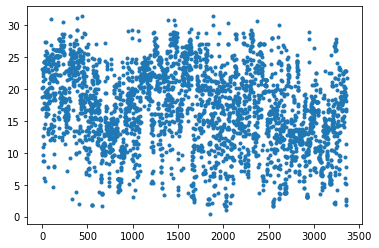

In [487]:
#***** feature importance and sequence score ******
# binding score prototype: SUM(feature200 importance dot feature200 vector) over all residues
# **** NEXT VERSION: also accounting clustering of positive binding residue ****

importances = model.feature_importances_
importances_scores = np.zeros(len(pep_data))
index = 0
for i in range(len(pep_data)):
    n_amino = len(A)
    importances_array = np.array([importances[:225] for j in range(n_amino)])
    importances_scores[i] = np.sum(X_pep_data[index:index+n_amino,:225]*importances_array)
    index += n_amino

pep_data["importances_scores"] = importances_scores

# plot score data 
plt.plot(importances_scores,'.')
plt.show()

In [521]:
# run the trained ML model

#y_pred_pep = model.predict(X_pep_data)    
#y_pred_pep_proba = model.predict_proba(X_pep_data)  

y_pred_pep = model.predict(X_pep_data[:,-28:])    
y_pred_pep_proba = model.predict_proba(X_pep_data[:,-28:])  


In [522]:
import networkx as nx

# predicted binding site and find total number of edges / triangles
bind_res_index_pred = []
bind_res_num_pred = []
n_edges = []
n_triangles = []
n_largest_cc = []

# specified only 1 protein
A, G, SC, sequence = network_from_PDB(protein_file)

# network with 10 Angs cutoff
A10, G10, SC10 = network_from_PDB_cutoff(protein_file,10)

index = 0
for i in range(len(pep_data)):
    entry = pep_data.entry.iloc[i]
    n_amino = len(A10)
    bind_res_index_ = np.where(np.array(y_pred_pep[index:index+n_amino]))[0]
    bind_res_index_pred.append(list(bind_res_index_))
    bind_res_num_pred.append(len(bind_res_index_))
    subarray = A10[bind_res_index_][:,bind_res_index_]
    n_edges.append(int(0.5*np.sum(subarray)))
    n_triangles.append(int(sum(nx.triangles(nx.from_numpy_matrix(subarray)).values())/3))
    if subarray.shape==(0,0):
        subarray = np.zeros((1,1))
    max_clust_size = int(max(np.sum(np.nan_to_num(np.ceil(expm(subarray))/np.ceil(expm(subarray))),axis=1)))
    n_largest_cc.append(max_clust_size)
    index += n_amino
    clear_output(wait=True)
    print(str(entry)+'/'+str(len(pep_data)))
pep_data['bind_res_index_pred'] = bind_res_index_pred
pep_data['bind_res_num_pred'] = bind_res_num_pred
pep_data['n_edges'] = n_edges
pep_data['n_largest_cc'] = n_largest_cc
pep_data['n_triangles'] = n_triangles 
pep_data['n_edges-n_triangles'] = np.array(n_edges) - np.array(n_triangles)                 
pep_data['(n_edges-n_triangles)/bind_res_num'] = (np.array(n_edges) - np.array(n_triangles))/np.array(pep_data.bind_res_num_pred)
pep_data['(n_edges-n_triangles)/n_edges'] = (np.array(n_edges) - np.array(n_triangles))/np.array(n_edges)

pep_data_positive = pep_data.dropna()
plt.plot(pep_data_positive['n_edges-n_triangles'],pep_data_positive['importances_scores'],'.')
plt.show()
plt.plot(pep_data_positive['n_largest_cc'],pep_data_positive['importances_scores'],'.')
plt.show()

3359/3360


/var/folders/03/ww9pl1zx1y162xj16ph_rcch0000gn/T/ipykernel_42428/1539417145.py:39: RuntimeWarning: invalid value encountered in true_divide
  pep_data['(n_edges-n_triangles)/bind_res_num'] = (np.array(n_edges) - np.array(n_triangles))/np.array(pep_data.bind_res_num_pred)
/var/folders/03/ww9pl1zx1y162xj16ph_rcch0000gn/T/ipykernel_42428/1539417145.py:40: RuntimeWarning: invalid value encountered in true_divide
  pep_data['(n_edges-n_triangles)/n_edges'] = (np.array(n_edges) - np.array(n_triangles))/np.array(n_edges)


KeyError: 'importances_scores'

In [491]:
pep_data_positive[pep_data_positive.n_largest_cc>=3].to_csv('rbd_screened.csv')
pep_data_positive[pep_data_positive.n_largest_cc>=3]

,Name,Source,peptide_seq,len_peptide_seq,Sequence_Complete,entry,importances_scores,bind_res_index_pred,bind_res_num_pred,n_edges,n_largest_cc,n_triangles,n_edges-n_triangles,(n_edges-n_triangles)/bind_res_num,(n_edges-n_triangles)/n_edges


In [513]:
pep_data[pep_data.bind_res_num_pred>0]

,Name,Source,peptide_seq,len_peptide_seq,Sequence_Complete,entry,importances_scores,bind_res_index_pred,bind_res_num_pred,n_edges,n_largest_cc,n_triangles,n_edges-n_triangles,(n_edges-n_triangles)/bind_res_num,(n_edges-n_triangles)/n_edges
435,"Brevinin-1CG2 (Frogs, amphibians, animals)",Amolops chunganensis (Chungan torrent frog),FLPIVAGLAANFLPKIVCKITKKC,24,1,315,24.732109,[34],1,0,1,0,0,0.0,NaN
438,"Brevinin-1CG5 (Frogs, amphibians, animals)",Amolops chunganensis (Chungan torrent frog),FLPMLAGLAANFLPKIVCKITKKC,24,1,318,24.732109,[34],1,0,1,0,0,0.0,NaN
781,Jellein-2 (Jelleine-II; chain of Major royal j...,Apis mellifera (Honeybee),TPFKISIHL,9,1,520,7.691753,[83],1,0,1,0,0,0.0,NaN
2483,"Amolopin-1c (Frogs, amphibians, animals)",Amolops loloensis (Rufous-spotted torrent frog),FLPMLAGLAANLLPKLFCKITKKC,24,1,1366,24.755000,[34],1,0,1,0,0,0.0,NaN
2874,Antimicrobial peptide 5 (XT-5; PGLa-like pepti...,Xenopus tropicalis (Western clawed frog) (Silu...,GMATKAGTALGKVAKAVIGAAL,22,1,1639,26.142380,[49],1,0,1,0,0,0.0,NaN
2885,"Electrin-5 (Frogs, amphibians, animals)",Litoria rubella (Desert tree frog),IYEPEIA,7,1,1649,4.726274,[120],1,0,1,0,0,0.0,NaN
2895,"Rhodei-litorin (Frogs, amphibians, animals)",Phyllomedusa rohdei (Rohde's leaf frog),QLWATGHFM,9,1,1655,7.467933,[83],1,0,1,0,0,0.0,NaN
2919,"Tryptophyllin-2 (Frogs, amphibians, animals)",Ascaphus truei (Coastal tailed frog),GPIPWQRRI,9,1,1679,7.973290,[83],1,0,1,0,0,0.0,NaN
2923,"Tryptophyllin-14 (Frogs, amphibians, animals)",Phyllomedusa centralis (Mato Grosso leaf frog),FPPWVL,6,1,1683,4.393023,[161],1,0,1,0,0,0.0,NaN
3336,"Dinoponeratoxin Da-1039 (ants, insects, animals)",Dinoponera australis (Giant neotropical huntin...,GVVPHDFRI,9,1,1800,7.240193,"[35, 83]",2,1,1,0,1,0.5,1.0
